In [1]:
import os
import sys
import time
import random
import warnings

import cv2 as cv
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from keras import backend as K

import tensorflow as tf

# Set some parameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

Using TensorFlow backend.


In [2]:
def acc_comp(msk, preds_test_t): #Takes as input 2D masks and 2D predictions
    
    mean_acc = np.zeros(1)

    for j in range(msk.shape[0]):
        act = msk[j]
        pr = preds_test_t[j].reshape(IMG_WIDTH, IMG_HEIGHT)
    
        c = act == pr #acc
        d = act & pr #true negative
        e = act | pr #true positive
        neg = act.sum()
        pos = (IMG_WIDTH*IMG_HEIGHT)-act.sum()
    
        TN = round(float(d.sum()),6)
        FN = round(float(pr.sum()-d.sum()),6)
        TP = round(float((IMG_WIDTH*IMG_HEIGHT)-e.sum()),6)
        FP = round(float(e.sum()-pr.sum()),6)
        acc = round(float(c.sum())/(IMG_WIDTH*IMG_HEIGHT),6)

        acc2 = float(TP+TN)/(TP+TN+FP+FN)
        mean_acc = np.append([mean_acc],acc)
    
    mean_acc = mean_acc[1:]
    avg = round(mean_acc.sum()/msk.shape[0],6)
    std = round(np.std(mean_acc),6)
    
    return (avg,std)

In [3]:
# Define class for extracting time per epoch
class TimingCallback(Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

cb = TimingCallback()

In [4]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [12]:
# Get Training Data (Original+Mask) DONT RUN IN THIS CODE 
# Dataset 1: HGR
TRAIN_PATH1 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset1_HGR/original_images/']
MASK_PATH1 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset1_HGR/skin_masks/']
train_ids1 = next(os.walk(TRAIN_PATH1[0]))[2]
mask_ids1 = next(os.walk(MASK_PATH1[0]))[2]
train_ids1.sort()
mask_ids1.sort()
TRAIN_PATH1 = TRAIN_PATH1*len(train_ids1)
MASK_PATH1 = MASK_PATH1*len(train_ids1)

# Dataset 4: Pratheepan
TRAIN_PATH2 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset4_Pratheepan/original_images/']
MASK_PATH2 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset4_Pratheepan/skin_masks/']
train_ids2 = next(os.walk(TRAIN_PATH2[0]))[2]
mask_ids2 = next(os.walk(MASK_PATH2[0]))[2]
train_ids2.sort()
mask_ids2.sort()
TRAIN_PATH2 = TRAIN_PATH2*len(train_ids2)
MASK_PATH2 = MASK_PATH2*len(train_ids2)

# Dataset 5: VDM
TRAIN_PATH3 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset5_VDM/original_images/']
MASK_PATH3 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset5_VDM/skin_masks/']
train_id3 = next(os.walk(TRAIN_PATH3[0]))[2]
mask_id3 = next(os.walk(MASK_PATH3[0]))[2]
train_id3.sort()
mask_id3.sort()
train_ids3 = train_id3[1:]
mask_ids3 = mask_id3[1:]
TRAIN_PATH3 = TRAIN_PATH3*len(train_ids3)
MASK_PATH3 = MASK_PATH3*len(train_ids3)

# Dataset 6: SFA
TRAIN_PATH4 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset6_SFA/original_images/']
MASK_PATH4 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset6_SFA/skin_masks/']
train_ids4 = next(os.walk(TRAIN_PATH4[0]))[2]
mask_ids4 = next(os.walk(MASK_PATH4[0]))[2]
train_ids4.sort()
mask_ids4.sort()
TRAIN_PATH4 = TRAIN_PATH4*len(train_ids4)
MASK_PATH4 = MASK_PATH4*len(train_ids4)

# Dataset 2: TDSD
TRAIN_PATH5 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset2_TDSD/original_images/']
MASK_PATH5 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset2_TDSD/skin_masks/']
train_ids5 = next(os.walk(TRAIN_PATH5[0]))[2]
mask_ids5 = next(os.walk(MASK_PATH5[0]))[2]
train_ids5.sort()
mask_ids5.sort()
TRAIN_PATH5 = TRAIN_PATH5*len(train_ids5)
MASK_PATH5 = MASK_PATH5*len(train_ids5)

# Dataset 3: Schmugge
TRAIN_PATH6 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset3_Schmugge/original_images/']
MASK_PATH6 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset3_Schmugge/skin_masks/']
train_ids6 = next(os.walk(TRAIN_PATH6[0]))[2]
mask_ids6 = next(os.walk(MASK_PATH6[0]))[2]
train_ids6.sort()
mask_ids6.sort()
TRAIN_PATH6 = TRAIN_PATH6*len(train_ids6)
MASK_PATH6 = MASK_PATH6*len(train_ids6)

# Combine everything
TRAIN_PATH = np.concatenate((TRAIN_PATH1,TRAIN_PATH2,TRAIN_PATH3,TRAIN_PATH4,TRAIN_PATH5,TRAIN_PATH6))
MASK_PATH = np.concatenate((MASK_PATH1,MASK_PATH2,MASK_PATH3,MASK_PATH4,MASK_PATH5,MASK_PATH6))
train_ids = np.concatenate((train_ids1,train_ids2,train_ids3,train_ids4,train_ids5,train_ids6))
mask_ids = np.concatenate((mask_ids1,mask_ids2,mask_ids3,mask_ids4,mask_ids5,mask_ids6))

In [14]:
# Get and resize train images and masks DONT RUN IN THIS CODE
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH[n] + id_
    img = imread(path)[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img

for n, id_ in tqdm(enumerate(mask_ids), total=len(mask_ids)):
    path = MASK_PATH[n] + id_
    img = imread(path)
    if n in range(899,977):
        img = img[:,:,1]
    img = np.expand_dims(resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
    Y_train[n] = img

Getting and resizing train images and masks ... 


100%|██████████| 3780/3780 [00:08<00:00, 462.94it/s]


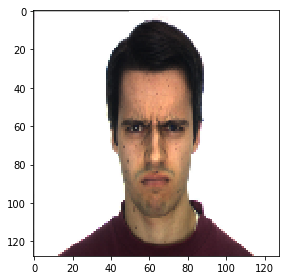

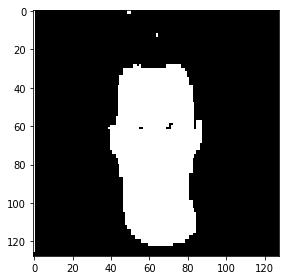

In [15]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

In [ ]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [ ]:
# Fit model
earlystopper = EarlyStopping(patience=20, verbose=1)
checkpointer = ModelCheckpoint('model-SFA-5Feb2019-batch64.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.3, batch_size=64, epochs=50, shuffle=True, 
                    callbacks=[earlystopper, checkpointer, cb])

In [ ]:
#print(results.history.keys())

# Summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Summarize history for mean_iou
plt.plot(results.history['acc'])
plt.plot(results.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Results and Plots
# model.summary()
print("UNET ARCHITECTURE")
print ("-------------------------------------------------------------")
print("Total num of training images: %d" % len(train_ids))
print("Max num of epochs: %d" % 50)
print("Optimizer: %s" % 'ADAM')
print("Batch size: %d" % 64)
print("Loss function: %s" % 'Binary Cross-Entropy')
print("Validation data percentage: %d" % 10)
print("Early stoppping: %s" % 'Yes')

ep = 50;
a = results.history["acc"]
b = results.history["loss"]
c = results.history["val_acc"]
d = results.history["val_loss"]
e = cb.times
print ("-------------------------------------------------------------")
header = "#"+"    "+"Time sec"+"      "+"Tr_acc"+"     "+"Tr_loss"+"      "+"Vl_acc"+"     "+"Vl_loss"
print(header)
print ("-------------------------------------------------------------")
for l in range(ep):
    str = "%d\t\t%f\t\t%f\t\t%f\t\t%f\t\t%f" % (l, round(e[l],4),round(a[l],4),round(b[l],4),round(c[l],4),d[l])
    print (str.expandtabs(2))
print ("-------------------------------------------------------------")

In [16]:
# Predict on train and validation tests
model = load_model('model-SFA-5Feb2019-batch64.h5', custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.7)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.7):], verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

1134/1134 [==============================] - 14s 12ms/step


In [ ]:
# Sanity check on random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

In [ ]:
# Sanity check on random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.7):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.7):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

In [17]:
# Compute Accuracy for Abdomen Set
ABD_PATH = '/home/lalzogbi/Documents/Skin_Datasets/Dataset_Test/testing_data/'
MSK_PATH = '/home/lalzogbi/Documents/Skin_Datasets/Dataset_Test/ground_truth/'
abd_ids = next(os.walk(ABD_PATH))[2]
msk_ids = next(os.walk(MSK_PATH))[2]
abd_ids.sort()
msk_ids.sort()

abd = np.zeros((len(abd_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
msk = np.zeros((len(msk_ids), IMG_HEIGHT, IMG_WIDTH), dtype=np.uint8)

sys.stdout.flush()
for n, id_ in tqdm(enumerate(abd_ids), total=len(abd_ids)):
    path = ABD_PATH + id_
    img = imread(path)[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    abd[n] = img
    
for n, id_ in tqdm(enumerate(msk_ids), total=len(msk_ids)):
    path = MSK_PATH + id_
    img = imread(path)
    
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True)
    img = (img > 15).astype(np.uint8)
    msk[n] = img
    
# Actual Predictions
preds_test = model.predict(abd[:int(abd.shape[0])], verbose=1)

# Threshold predictions
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Overall accuracy on abdomen pictures
acc_comp(msk, preds_test_t)

100%|██████████| 50/50 [00:00<00:00, 134.92it/s]


50/50 [==============================] - 1s 11ms/step


(0.884492, 0.109834)

In [ ]:
# Visualize Predictions
for n in range(len(abd_ids)-1):
    #ix = random.randint(0, len(abd_ids)-1)
    imshow(abd[n])
    plt.show()
    imshow(np.squeeze(preds_test_t[n]))
    plt.show()